## Introduction

In our previous lesson, we used a scatterplot to look at pairs of features from the data set in an effort to determine which pair would be best for predicting a flower's species. At the time, we didn't know how to show more than one plot in a single figure, so it was tough to compare the different feature pairings to find the best predictor, but in this lesson we'll see how to display multiple plots in a single figure using the `subplot` function. 

But, before we can learn anything about subplotting, we need to setup our notebook and pull in a data set, so let's go ahead and do that now.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

## Getting the Data

Once again, we'll be using the [Iris data set][1] from the [UCI Machine Learning Repository][2] to play around with matplotlib's subplotting features. The code below was taken from the earlier lessons and will download and load the data set into a variable called `data`.

[1]: https://archive.ics.uci.edu/ml/datasets/Iris
[2]: http://archive.ics.uci.edu/ml/

In [2]:
import csv
import urllib2
from collections import namedtuple

# Create a namedtuple constructor for each record in the Iris data
#    1. sepal length in cm
#    2. sepal width in cm
#    3. petal length in cm
#    4. petal width in cm
#    5. class: 
#       -- Iris-setosa
#       -- Iris-versicolour
#       -- Iris-virginica
fields = ('sepal_length', 
          'sepal_width', 
          'petal_length', 
          'petal_width', 
          'species')
IrisRecord = namedtuple('IrisRecord', fields)

# Download and read in the data from the UCI Machine Learning Repository
response = urllib2.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
iris_data_csv = response.read().strip()

# Convert each record into a format that's easier to work with (i.e.,
# wrap each record in the namedtuple that we created).
data = []
for row in csv.reader(iris_data_csv.splitlines()):
    data.append(IrisRecord(
        sepal_length          = float(row[0]),
        sepal_width           = float(row[1]),
        petal_length          = float(row[2]),
        petal_width           = float(row[3]),
        species               = row[4]))

## Creating the `scatter` Function

Now, we could copy and paste the code we used for drawing our scatterplots for each plot we want to make, but that's a bit tedious and error prone. So, for this lesson, we'll grab the code from the 'More Plotting' lesson, and wrap it in a function that will allow us to create scatterplots for different pairs of features with just a single line of code.

The code below creates a function called `scatter` that takes a 2D matrix of data and several keyword variables that allow us to describe which data we wish to plot as well as some of the aesthetic attributes of the plot such as `x` and `y` labels and legend location.

In [3]:
from itertools import cycle
from collections import defaultdict

def scatter(m, x=None, y=None, target=None, x_label=None, y_label=None, loc='upper right'):
    """Takes a 2D matrix and keys for getting the x and y values
    
    The x, y, and target parameters are either getter functions 
    that will be used to extract their corresponding values from
    each row, or they are strings which will be used with the
    getattr function to extract the value. If None, it is assumed
    that the x and y values are the first and second in the row
    and the target value is the last value in the row.
    """        
    # Create a color map of species names to colors
    color_cycler = cycle(plt.rcParams['axes.prop_cycle'])
    cmap = defaultdict(lambda: next(color_cycler)['color'])
    
    # Create the x, y, and target values getter functions,
    # and create human readable x and y labels if none 
    # were passed in.
    if x is None:
        x_getter = lambda r: r[0]
    elif isinstance(x, basestring):
        if x_label is None:
            x_label = x.replace('_', ' ').title()
        x_getter = lambda r: getattr(r, x) 
    else:
        x_getter = x
        
    if y is None:
        y_getter = lambda r: r[1]
    elif isinstance(y, basestring):
        if y_label is None:
            y_label = y.replace('_', ' ').title()
        y_getter = lambda r: getattr(r, y) 
    else:
        y_getter = y
        
    if target is None:
        target_getter = lambda r: r[-1]
    elif isinstance(target, basestring):
        target_getter = lambda r: getattr(r, target)
    else:
        target_getter = target
    
    # Extract the x and y values (i.e., sepal length and width)
    # from the data set. Also, create a list of corresponding
    # colors based on the species of each record.
    _x, _y, colors = [], [], []
    for r in data:
        _x.append(x_getter(r))
        _y.append(y_getter(r))
        colors.append(cmap[target_getter(r)])

    # Plot the data on a scatter plot. Each point will have an outline 
    # color according to their species, but we'll leave the centers 
    # colorless (for aesthetic purposes only). Finally, we'll reduce
    # the line width of each data point (again for aesthetics only).
    plt.scatter(_x, _y, edgecolors=colors, c='none', linewidths=0.5)

    # Add x and y labels
    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel(y_label)
    
    # Get the list of classes for the target variable
    classes = list(set(r[-1] for r in m))

    # Create a few "proxy artists" for creating the legend. Calling the 
    # legend() function without passing in any parameters will create a
    # legend for any labeled data in the graph, so we could do something
    # funky where we add a label for one line per species, but that 
    # doesn't seem as simple and clean as just creating a few lines that
    # we use just to create the legend. Plus, this is an officially 
    # sanctioned way to create a legend (just see the legend docs).
    legend_handles = [plt.Line2D([], [], color=cmap[cls], label=cls) for cls in classes]
    plt.legend(handles=legend_handles, loc=loc);

## Drawing Multiple Plots With `subplot`

The `subplot` function can be used to create a single plot in a grid of subplots. It takes three integer values: the first two describe the shape of the grid and the third is the index of the subplot you want to create. So, for example, if we wanted to create a pair of subplots, one beside the other horizontally, we would call the `subplot` function with the first number set to 1, to signify that our grid will have 1 row, and the second number set to 2, to signify that our grid will contain 2 columns. Our grid would then contain 2 sublots, numbered 1 and 2, since the `subplot` function assumes that subplots are indexed starting at 1.

Let's try creating that horizontal grid of subplots now. 

The very first thing we'll do is adjust the width of our figure slightly, otherwise, we'll end up with two very narrow subplots since the default width is only appropriate for a single plot. On line 2, you can see the code makes a call to the `pyplot.gcf` function to get the current `Figure` object, and then it calls the `Figure.set_figwidth` function to adjust the width of the figure. Next, on line 5, we'll call the `subplot` function to create the first plot in the grid. This call will create an instance of the `Axes` class and set it as the current axes object on the current figure. Then, we'll call the `scatter` function we created above, pass in our data, and specify the sepal length and width as the features we want to show in our first plot.

To plot the second scatterplot, you simply call the `subplot` function again with the same number of rows and columns, but this time with the index value of the next plot in the grid, that would be the number 2 in this case. Notice, in this call, however, that we are passing in the single value `122` rather than three separate integer values. This is a shorthand that the `subplot` function allows if you have a grid that has less than 10 subplots in it. Finally, on the last line, we call our `scatter` function again, this time with the petal dimensions and a different location for the legend so as to not obscure the data in the graph.

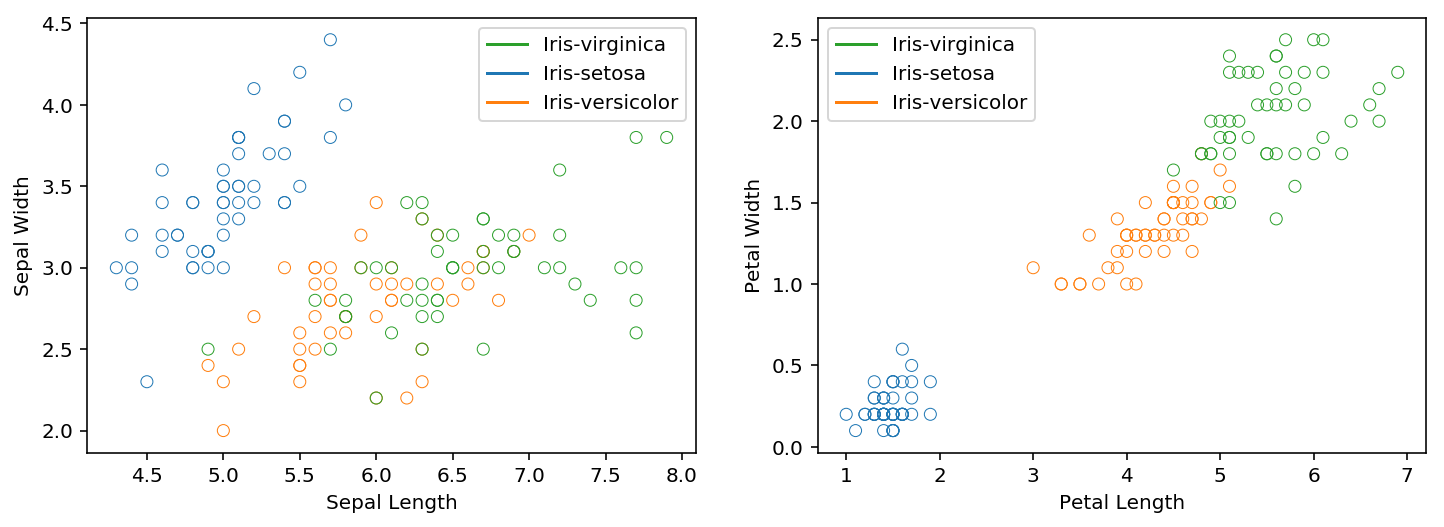

In [6]:
# Adjust the width to fit two plots side-by-side
plt.gcf().set_figwidth(12)

# Create the first plot in a 1x2 grid
plt.subplot(1,2, 1)
scatter(data, 'sepal_length', 'sepal_width')

# Create the second plot in a 1x2 grid.
# For grids that have less than 10 subplots, you can use
# the shorthand below where you leave out the commas between
# the number of rows, number of columns, and index values.
plt.subplot(122)
scatter(data, 'petal_length', 'petal_width', loc='upper left')

Looks pretty nice, right? And, viewing the data side-by-side like this makes it so much easier to see the magnitude of the effect that different feature pairs have on the clustering of our data. 

Let's switch it up a little bit though, and do the same thing vertically. The code below displays the same set of scatterplots, but this time, we'll display them in a single column instead of a single row. We'll also use the `subplots` function this time to create the entire grid of `Axes` objects ahead of time. 

The important lines in this code are lines 5, 13, and 17. First, take a look at line 5. As I mentioned, this time around we're calling the `subplots` function instead of the singular `subplot` function. The difference is that `subplot` creates only a single `Axes` object when it's called, so you build up your grid one `Axes` object at a time. The `subplots` function, on the other hand, creates the entire grid of `Axes` objects at once and returns them, along with the current `Figure`, in a tuple. On line 5, we call the `subplots` function to create a 2 row by 1 column grid, and we capture the `Axes` objects returned in the variables `ax1` and `ax2`.

On lines 13 and 17, we see next bit of code that differs from the previous example. Since we're no longer creating each subplot as we need them, we'll need to set the current subplot, or axes, before we can draw each scatterplot. To do so, we have to call the set current axes function, `plt.sca`, and pass in the `Axes` object that we want to plot our data on. Once we've set the current axes, we can call our `scatter` function and it will draw the scatterplot using the `Axes` object we just set as the current axes.

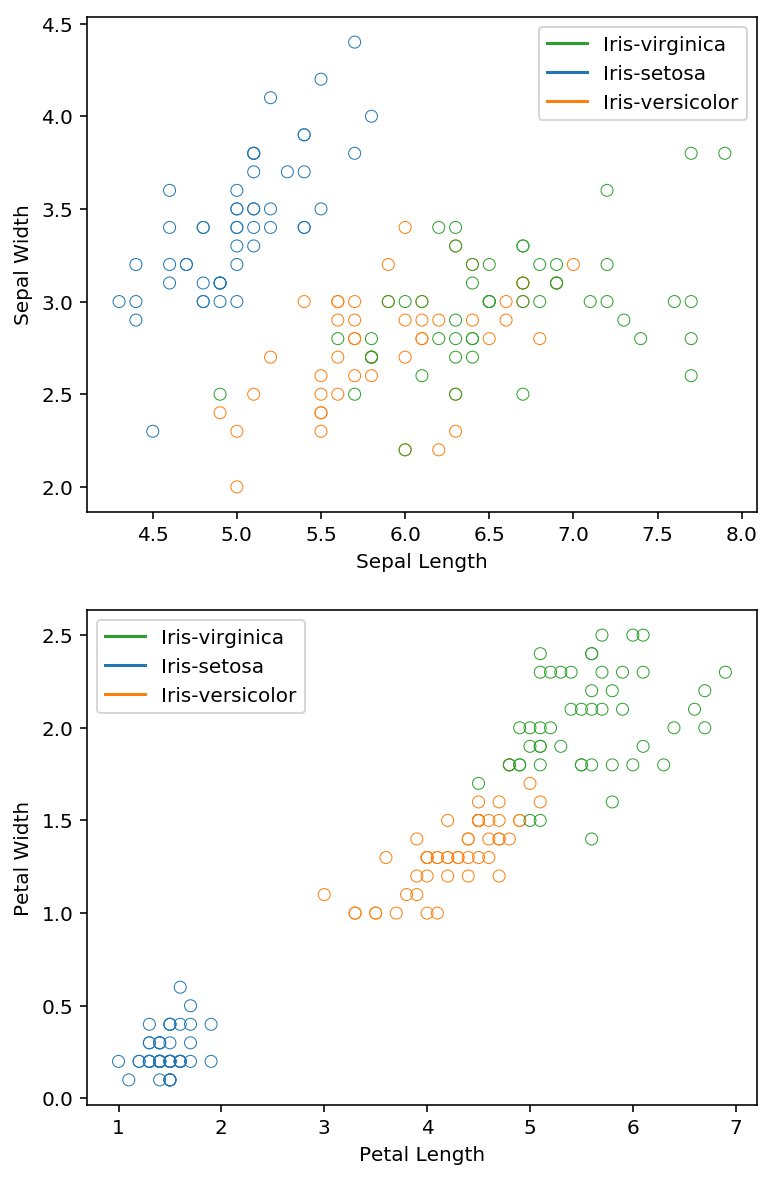

In [7]:
# The difference between the subplot and subplots
# functions is that the former creates a single 
# axes object every time it's called, whereas the
# the latter creates all of the axes objects at once.
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figheight(10)

# Since we created all of the xes objects ahead of time, 
# we have to set the current axes ourselves before calling
# the scatter function. Below we set the current axes to 
# the first Axes object before plotting the sepal dimensions.
plt.sca(ax1)
scatter(data, 'sepal_length', 'sepal_width', loc='upper right')

# Plot the petal dimensions in the second axes
plt.sca(ax2)
scatter(data, 'petal_length', 'petal_width', loc='upper left')

## Conclusion

And, that will bring this lesson to a close.  We just saw how to use the `subplot` and `subplots` functions to create grids of plots making it infinitely easier for us to compare different feature sets in our data. In the next lesson, we'll see how to make some minor adjustments to a few of subplot parameters to make our plots easier to read and comprehend.